In [1]:
%load_ext slim_magic
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import display, SVG

# slim_magic examples
First let's set up a simple, single locus simulation of drift. The cell below contains all the
SLiM code to be run. We hand that to a magic function, in this case `slim_stats_reps_cstack` along with
the required parameters of that function. In this case `slim_stats_reps_cstack` wants to know the number of reps
to run as well as optionally a variable name to store resulting output.

In [2]:
%%slim_stats_reps_cstack 200 --out output_from_magic
// set up a single locus simulation of drift
initialize()
{
    // set the overall mutation rate
    initializeMutationRate(0);
    // m1 mutation type: neutral
    initializeMutationType("m1", 0.5, "f", 0.0);
    // g1 genomic element type: uses m1 probability 1
    initializeGenomicElementType("g1", c(m1), c(1.0));
    // uniform chromosome of length 1 site
    initializeGenomicElement(g1, 0, 0);
    // uniform recombination along the chromosome
    initializeRecombinationRate(1e-8);
    suppressWarnings(T);
}

// create a population of 100 individuals
1 {
    sim.addSubpop("p1", 100);
    // sample 100 haploid genomes 
    target = sample(p1.genomes, 100);
    // add a mutation to those genomes
    // H_0 = 0.5 here
    target.addNewMutation(m1,0, 0);
    log = sim.createLogFile("/dev/stdout", logInterval=1);
    log.addGeneration();
    log.addCustomColumn("H", "calcHeterozygosity(p1.genomes);"); 
}

// run to generation 0
300 late() {
    sim.simulationFinished();
    }


In [4]:
output_from_magic 

,H,H,H,H,H,H,H,H,H,H,...,H,H,H,H,H,H,H,H,H,H
generation,,,,,,,,,,,,,,,,,,,,,
1,0.49820,0.49875,0.49955,0.49680,0.49980,0.49875,0.49920,0.49755,0.49920,0.49995,...,0.49680,0.49395,0.49875,0.50000,0.48720,0.49755,0.49920,0.49995,0.49920,0.49995
2,0.49980,0.49020,0.49980,0.49755,0.49500,0.48875,0.49395,0.49820,0.49875,0.49995,...,0.48720,0.49820,0.49995,0.49875,0.49995,0.49755,0.49980,0.49980,0.49155,0.48720
3,0.49995,0.46080,0.49995,0.49755,0.49595,0.46620,0.48380,0.49155,0.49875,0.49500,...,0.48875,0.49680,0.48875,0.49155,0.49395,0.49595,0.49980,0.49755,0.49500,0.47120
4,0.49755,0.43155,0.49875,0.49820,0.49995,0.46080,0.48380,0.49500,0.49995,0.48380,...,0.48875,0.49820,0.48380,0.49500,0.49680,0.49155,0.49595,0.49280,0.48380,0.48195
5,0.47580,0.47120,0.49395,0.48380,0.49755,0.48875,0.49395,0.49595,0.49955,0.47120,...,0.49020,0.49595,0.47580,0.46080,0.49955,0.49995,0.47795,0.49755,0.47580,0.49020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0.25500,0.00000,0.38480,0.00000,0.09500,0.00000,0.40320,0.00000,0.00000,0.00000,...,0.00000,0.06755,0.00000,0.00000,0.31395,0.00000,0.49980,0.26880,0.00000,0.49980
297,0.26195,0.00000,0.36995,0.00000,0.09500,0.00000,0.41595,0.00000,0.00000,0.00000,...,0.00000,0.10395,0.00000,0.00000,0.36480,0.00000,0.49920,0.23355,0.00000,0.49755
298,0.25500,0.00000,0.34875,0.00000,0.09500,0.00000,0.41180,0.00000,0.00000,0.00000,...,0.00000,0.05820,0.00000,0.00000,0.32000,0.00000,0.49820,0.25500,0.00000,0.49875


In [5]:
# function for drift expectation
def exp_decay_drift(H0, N, gens):
    res = [H0]
    h = H0
    for i in range(gens):
        tmp = h * (1 - (1 / (2*N)))
        res.append(tmp)
        h = tmp
    return res

e = exp_decay_drift(0.5, 100, 299)

plot mean Heterozygosity across reps versus the expected value

<AxesSubplot:xlabel='generation', ylabel='heterozygosity'>

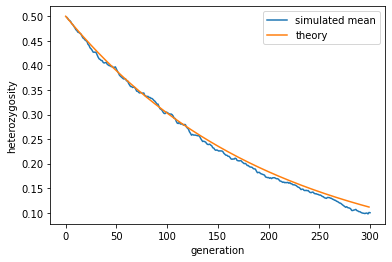

In [6]:
x.mean(axis=1).plot(ylabel="heterozygosity", label="simulated mean", legend=True)
pd.Series(e).plot(label="theory",legend="True")

## Hardy Weinberg

In [7]:
%%slim_stats_reps_rstack 10 --out df
// set up a single locus simulation of drift
initialize()
{
    // set the overall mutation rate
    initializeMutationRate(0);
    // m1 mutation type: neutral
    initializeMutationType("m1", 0.5, "f", 0.0);
    // g1 genomic element type: uses m1 probability 1
    initializeGenomicElementType("g1", c(m1), c(1.0));
    // uniform chromosome of length 1 site
    initializeGenomicElement(g1, 0, 0);
    // uniform recombination along the chromosome
    initializeRecombinationRate(1e-8);
    suppressWarnings(T);
}

// create a population of 100 individuals
1 {
    sim.addSubpop("p1", 100);
    // sample 100 haploid genomes 
    target = sample(p1.genomes, 100);
    // add a mutation to those genomes
    // H_0 = 0.5 here
    target.addNewMutation(m1,0, 0);
    cat("generation,p,x11,x12,x22\\n");
}
1:300 late(){
    inds = p1.sampleIndividuals(100);
    ind_count = inds.countOfMutationsOfType(m1);
    counts = c(0, 0, 0);
    for (x in ind_count)
        counts[x] = counts[x] + 1;
    counts = counts / 100;
    freqs = sim.mutationFrequencies(p1);
    if (length(freqs) > 0.0)
        catn(sim.generation + "," + freqs + "," + paste(counts, sep=","));
    }
// run to generation 0
300 late() {
    sim.simulationFinished();
    }


## HWE Expectations
let's write a function to compute the HW expected genotype frequencies from the allele frequency, $p$

In [8]:
def hwe(p):
    return np.array([p**2, 2 * p * (1 - p), (1 - p)**2])

#run that function for 100 pts between (0,1)
expected = hwe(np.linspace(0,1,100))

Text(0, 0.5, 'genotype frequency')

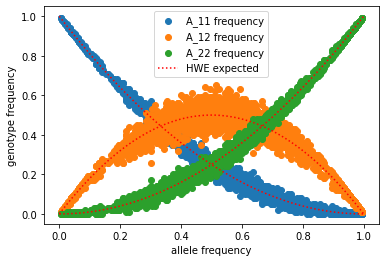

In [9]:
#plot simulated
plt.scatter(df.p, df.x11, label="A_11 frequency")
plt.scatter(df.p, df.x12, label="A_12 frequency")
plt.scatter(df.p, df.x22, label="A_22 frequency")


#plot expected
plt.plot(np.linspace(0,1,100),expected[0,:], c="red", linestyle="dotted", label="HWE expected")
plt.plot(np.linspace(0,1,100),expected[1,:], c="red", linestyle="dotted")
plt.plot(np.linspace(0,1,100),expected[2,:], c="red", linestyle="dotted")

plt.legend()
plt.xlabel("allele frequency")
plt.ylabel("genotype frequency")

# Deviations from HWE
let's simulate a deviation from HWE and compare the output to above

In [10]:
%%slim_stats_reps_rstack 10 --out df
// set up a single locus simulation of drift
initialize()
{
    // set the overall mutation rate
    initializeMutationRate(0);
    // m1 mutation type: neutral
    initializeMutationType("m1", 0.5, "f", 0.0);
    // g1 genomic element type: uses m1 probability 1
    initializeGenomicElementType("g1", c(m1), c(1.0));
    // uniform chromosome of length 1 site
    initializeGenomicElement(g1, 0, 0);
    // uniform recombination along the chromosome
    initializeRecombinationRate(1e-8);
    suppressWarnings(T);
}

// create a population of 100 individuals
1 {
    sim.addSubpop("p1", 50);
    sim.addSubpop("p2", 50);
    // sample 100 haploid genomes 
    target = sample(p1.genomes, 50);
    // add a mutation to those genomes
    // H_0 = 0.5 here
    target.addNewMutation(m1,0, 0);
    cat("generation,p,x11,x12,x22\\n");
}
1:300 late(){
    inds1 = p1.sampleIndividuals(50);
    inds2 = p2.sampleIndividuals(50);
    inds = c(inds1, inds2);
    ind_count = inds.countOfMutationsOfType(m1);
    counts = c(0, 0, 0);
    for (x in ind_count)
        counts[x] = counts[x] + 1;
    counts = counts / 100;
    freqs1 = sim.mutationFrequencies(p1);
    freqs2 = sim.mutationFrequencies(p2);
    freqs = freqs1 + freqs2;
    if (length(freqs) > 0.0)
        catn(sim.generation + "," + freqs + "," + paste(counts, sep=","));
    }
// run to generation 0
300 late() {
    sim.simulationFinished();
    }


Text(0, 0.5, 'genotype frequency')

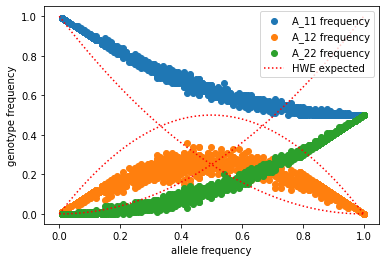

In [11]:
#plot simulated
plt.scatter(df.p, df.x11, label="A_11 frequency")
plt.scatter(df.p, df.x12, label="A_12 frequency")
plt.scatter(df.p, df.x22, label="A_22 frequency")


#plot expected
plt.plot(np.linspace(0,1,100),expected[0,:], c="red", linestyle="dotted", label="HWE expected")
plt.plot(np.linspace(0,1,100),expected[1,:], c="red", linestyle="dotted")
plt.plot(np.linspace(0,1,100),expected[2,:], c="red", linestyle="dotted")

plt.legend()
plt.xlabel("allele frequency")
plt.ylabel("genotype frequency")

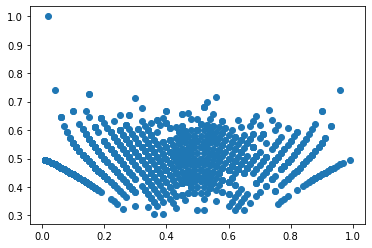

In [11]:
# Plot F as a function of allele frequency here
F = 1.0 - (df.x12 / (2 * df.p * (1-df.p)))
plt.scatter(df.p,F)

## Tree Sequences
`%%slim_ts` will return a tree sequence object from slim

In [12]:
%%slim_ts --out ts
// set up a simulation of drift
initialize()
{
    // set tree seq recording
    initializeTreeSeq(checkCoalescence=T);
    // set the overall mutation rate
    initializeMutationRate(1e-7);
    // m1 mutation type: neutral
    initializeMutationType("m1", 0.5, "f", 0.0);
    // g1 genomic element type: uses m1 probability 1
    initializeGenomicElementType("g1", c(m1), c(1.0));
    // uniform chromosome of length 1 site
    initializeGenomicElement(g1, 0, 10000);
    // uniform recombination along the chromosome
    initializeRecombinationRate(1e-7);
    suppressWarnings(T);
}

// create a population of 100 individuals
1 {
    sim.addSubpop("p1", 100);
}

// run to generation 0
300 late() {
    sim.treeSeqOutput("tmp.trees");
    sim.simulationFinished();
    }

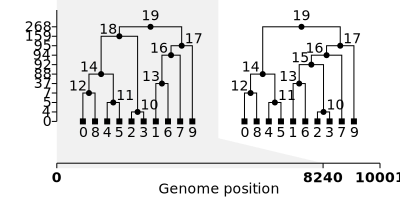

In [13]:
# simplify ts to 10 samples and draw pretty pic
tss = ts.simplify(samples=ts.samples()[0:10])

svg_string = tss.draw_svg(
    y_axis=True, y_label=" ",  # optional: show a time scale on the left
    time_scale="rank", 
)
display(SVG(svg_string))  # If the last line in a cell, wrapping this in display() is not needed

In [14]:
print(tss.draw_text())

268.00┊           19        ┊          19         ┊  
      ┊       ┏━━━━┻━━━━┓   ┊    ┏━━━━━━┻━━━━━┓   ┊  
159.00┊      18         ┃   ┊    ┃            ┃   ┊  
      ┊    ┏━━┻━━┓      ┃   ┊    ┃            ┃   ┊  
95.00 ┊    ┃     ┃     17   ┊    ┃           17   ┊  
      ┊    ┃     ┃    ┏━┻━┓ ┊    ┃          ┏━┻━┓ ┊  
94.00 ┊    ┃     ┃   16   ┃ ┊    ┃         16   ┃ ┊  
      ┊    ┃     ┃   ┏┻━┓ ┃ ┊    ┃       ┏━━┻━┓ ┃ ┊  
92.00 ┊    ┃     ┃   ┃  ┃ ┃ ┊    ┃      15    ┃ ┃ ┊  
      ┊    ┃     ┃   ┃  ┃ ┃ ┊    ┃     ┏━┻━┓  ┃ ┃ ┊  
88.00 ┊   14     ┃   ┃  ┃ ┃ ┊   14     ┃   ┃  ┃ ┃ ┊  
      ┊  ┏━┻━┓   ┃   ┃  ┃ ┃ ┊  ┏━┻━┓   ┃   ┃  ┃ ┃ ┊  
37.00 ┊  ┃   ┃   ┃  13  ┃ ┃ ┊  ┃   ┃  13   ┃  ┃ ┃ ┊  
      ┊  ┃   ┃   ┃  ┏┻┓ ┃ ┃ ┊  ┃   ┃  ┏┻┓  ┃  ┃ ┃ ┊  
7.00  ┊ 12   ┃   ┃  ┃ ┃ ┃ ┃ ┊ 12   ┃  ┃ ┃  ┃  ┃ ┃ ┊  
      ┊ ┏┻┓  ┃   ┃  ┃ ┃ ┃ ┃ ┊ ┏┻┓  ┃  ┃ ┃  ┃  ┃ ┃ ┊  
5.00  ┊ ┃ ┃ 11   ┃  ┃ ┃ ┃ ┃ ┊ ┃ ┃ 11  ┃ ┃  ┃  ┃ ┃ ┊  
      ┊ ┃ ┃ ┏┻┓  ┃  ┃ ┃ ┃ ┃ ┊ ┃ ┃ ┏┻┓ ┃ ┃  ┃  ┃ ┃ ┊  
4.00  ┊ ┃ ┃ ┃ ┃ 10  ┃ ┃ ┃ ┃ 